In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import cmocean as cmo 

dst = xr.open_dataset("population_dataset_time_INIT1.nc")

N = len(dst.kappa)
NT = len(dst.t)


hr2s = 1/3600
wm = 0.5 * hr2s
wd = 0.05 * hr2s
n2 = 1e-4
Ld = 0.006 * hr2s
Lm  = 0.004 * hr2s
growth_m = 0.05 * hr2s
growth_d = 0.008 * hr2s


In [2]:
# Functions
def steady_state(H, R, kappa, d2, m2, n1):

    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)

    return (d1, m1)


def field_at_point(R, H, kappa, m1, m2, d1, d2, n1, n2):
    h1 = R*H 
    h2 = H - h1     
         
    #       advection        diffusion       loss      growth
    f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + growth_m*n1*m1    # surface Microcystis
    f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
    f3 = (-wd/h1)*d1  + kappa/h1 * (d2 - d1) - Ld*d1 + growth_d*n1*d1      # surface diatoms
    f4 = ( wd/h2)*d1  + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
    f5 = kappa/h1 * (n2 - n1) - (m1*growth_m)*n1  - (d1*growth_d)*n1 

    return f1, f2, f3, f4, f5

def second_derivative(R, H,kappa, m1, m2, d1, d2, n1, n2):
    f1prime = (H*R*(R - 1)*(Lm*(H*R*m1*(Lm - growth_m*n1) + kappa*(m1 - m2) - m2*wm) - 
                growth_m*(m1*(H*R*n1*(d1*growth_d + growth_m*m1) + kappa*(n1 - n2)) 
                + n1*(H*R*m1*(Lm - growth_m*n1) + kappa*(m1 - m2) - m2*wm))) 
                - R*wm*(H*Lm*m2*(R - 1) + kappa*(m1 - m2) - m2*wm) - kappa*(H*R*(R - 1)*(-Lm*m1 + Lm*m2 + growth_m*m1*n1) + R*(kappa*(m1 - m2) - m2*wm) + (R - 1)*(-kappa*(m1 - m2) + m2*wm)))/(H**2*R**2*(R - 1))
    return f1prime

In [3]:
colors = [ "#F2B707",  "#9F22F2", "#BF0F0F"]

Time scale of advection is :  31950.0  seconds
Time scale of diffusion is :  187127.83  seconds
Time scale of growth is :  72000.0  seconds
largest valu, smallest value: 
0.01151952836025056 0.0001317624873167601
Second derivative is:  -3.1078504741675883e-12
Second derivative is:  -9.11069199605097e-13
Second derivative is:  -2.8260177895219106e-13


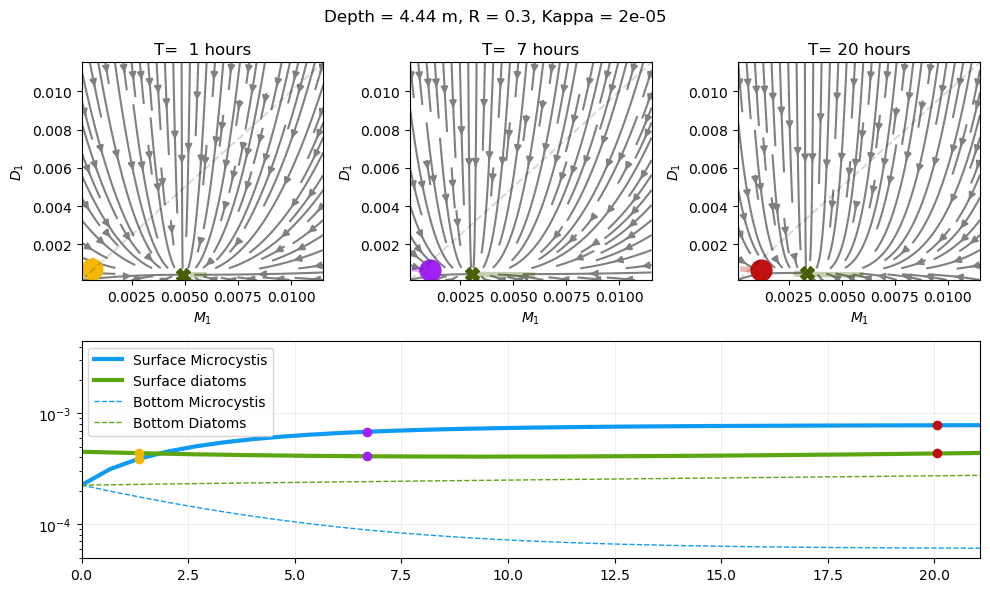

In [18]:
# Snapshot of three time frames 
# TIMES = [6, 80, 290]
TIMES = [2, 10, 30]

# id = 8
# ir = 5 
# ik = 6

id = 1
ir = 5 
ik = 14
MM = 0.001 # largest_val


depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]
h1 = ratio * depth
h2 = depth - h1

steadyD, steadyM = steady_state(depth, ratio, kappa, dst.d2.values[:, id ,ir,ik], dst.m2.values[:, id ,ir,ik], dst.n1.values[:, id ,ir,ik])

txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

print("Time scale of advection is : ", depth/wm, " seconds")
print("Time scale of diffusion is : ", depth/kappa, " seconds")
print("Time scale of growth is : "   , 1/growth_m, " seconds")


NN = 2

largest_val = max(max(dst.d1.isel(t=TIMES).values.ravel()), max(dst.m1.isel(t=TIMES).values.ravel())) 
largest_val2 = max(max(steadyD), max(steadyM))
largest_val = max(largest_val, largest_val2)* 1.1


min_val = min(min(dst.d1.isel(t=TIMES).values.ravel()), min(dst.m1.isel(t=TIMES).values.ravel()) * 0.95) 
min_val2 = min(min(steadyD), min(steadyM)) * 0.9
min_val = min(min_val, min_val2)
print("largest valu, smallest value: ")
print(largest_val, min_val)
# largest_val = 1.5 #0.0014
# min_val = 0 

x = np.linspace(min_val, largest_val, NN)
y = np.linspace(min_val, largest_val, NN)
X, Y = np.meshgrid(x, y)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharey=False, sharex=False)

txt = "Depth = %2.2f m R = %2.1f Kappa = %1.0e" % (depth, ratio, kappa)
fig.suptitle("Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa))
axs = axs.flatten()

gs = axs[1].get_gridspec()
axs[3].remove()
axs[4].remove()
axs[5].remove()
axl = fig.add_subplot(gs[3:])

hours = dst.t.values/3600
axl.plot(hours, dst.m1.values[:, id ,ir,ik]/h1, label=r"Surface Microcystis", color='#0F9BF2', linewidth=3)
axl.plot(hours, dst.d1.values[:, id ,ir,ik]/h1, label=r"Surface diatoms", color='#5CA612', linewidth=3)
axl.plot(hours, dst.m2.values[:, id ,ir,ik]/h2, '--', label=r"Bottom Microcystis", color='#0F9BF2', linewidth=1)
axl.plot(hours, dst.d2.values[:, id ,ir,ik]/h2, '--',  label=r"Bottom Diatoms", color='#5CA612', linewidth=1)
axl.grid(alpha=0.2)
axl.legend() 
axl.set_xlim(0, dst.t.values[TIMES[-1]]/3600+1)

for ai,it in enumerate(TIMES):
    
    hour = dst.t.values[it]/3600
    d1 = dst.d1.values[it, id ,ir, ik]
    d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir, ik]
    m2 = dst.m2.values[it, id ,ir, ik]
    n1 = dst.n1.values[it, id ,ir, ik]

    # Add current point to time series
    axl.plot(hour, dst.m1.values[it, id ,ir,ik]/h1 , 'o', color=colors[ai])
    axl.plot(hour, dst.d1.values[it, id ,ir,ik]/h1 , 'o', color=colors[ai])

    # Get phase diagram @ that local state 
    f1, f2, f3, f4, f5 = field_at_point(ratio, depth, kappa, X, m2, Y, d2, n1, n2)
    U = f1  # dM1/dt
    V = f3  # dD1/dt
    axs[ai].streamplot(x, y, U, V,  color="gray")

    # Add trajectory to axis
    axs[ai].plot( dst.m1.values[0:it+1, id ,ir,ik], dst.d1.values[0:it+1, id ,ir,ik], '-', color=colors[ai], alpha=0.3, linewidth=4)
    axs[ai].plot(m1, d1, 'o', color=colors[ai], markersize=15, label="Current state")
    
    # Add local steady-state to axis 
    # d11, m11 = steady_state(depth, ratio, kappa, d2, m2, n1)
    
    d2m1 = second_derivative(ratio, depth, kappa, m1, m2, d1, d2, n1, n2)
    print("Second derivative is: ", d2m1)
    axs[ai].plot(steadyM[it], steadyD[it], 'X', color="#466003", markersize=10, label="Local steady-state")
    axs[ai].plot(steadyM[0:it], steadyD[0:it], '-', color="#466003", alpha=0.3, linewidth=4)

    # Set up the axis 
    axs[ai].plot([min_val, largest_val], [min_val, largest_val], '--', color='black', alpha=0.15)
    axs[ai].set_xlabel(r"$M_1$")
    axs[ai].set_ylabel(r"$D_1$")
    axs[ai].set_title("T= %2.0f hours" % (hour))
    axs[ai].set_xlim(min_val, largest_val)
    axs[ai].set_ylim(min_val, largest_val)


axl.set_yscale("log")
# axs[0].legend(fontsize=10, loc='upper left')
plt.tight_layout()
fig.savefig("gif/snapshots_%s.png"  % txt)

Depth =  4.5  Ratio =  0.3857143  Kappa =  1.9306976e-06


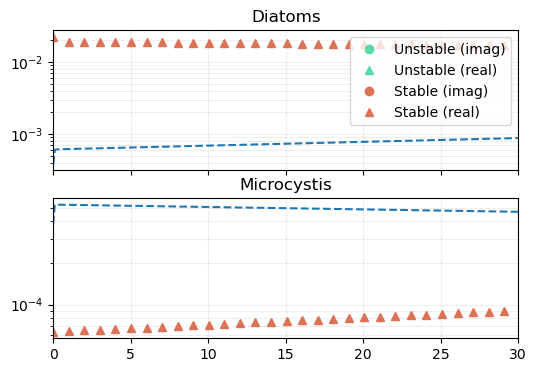

In [146]:
def jacobian(kappa, h1, h2, m1, m2, d1, d2, n1):
    j = np.array([[(-kappa/h1 + growth_m*n1 - Lm),  (kappa/h1 + wm/h1),     0,      0,    growth_m*m1],
                    [kappa/h2,  (-wm/h2 - kappa/h2 - Lm),   0,     0,        0],
                    [0, 0,  (-wd/h1 - kappa/h1 + growth_d*n1 - Ld),     kappa/h1,   growth_d*d1],
                    [0,   0,  (wd/h2 + kappa/h2),     (-kappa/h2 - Ld),   0],
                    [-growth_m*n1,     0,  -growth_d*n1,    0,  (-kappa/h1 - growth_d*d1 - growth_m*m1)]])
    eig = np.linalg.eigvals(j)
    # vars = ['m1', 'm2', 'd1', 'd2', 'n1']
    # for v,e in zip(vars,eig):
    #     print("%s = %1.2e" % (v,e))

    # Check to see if there's an imaginary part to any eigenvalue
   
    if np.any(np.real(eig) > 0): # unstable 
        if np.any(np.imag(eig) != 0) :
            return eig, -2
        else: 
            return eig, 2 
    
    else:
        if np.any(np.imag(eig) != 0) :
            return eig, -1
        else: 
            return eig, 1 
        

id = 1
ir = 5 
ik = 2


print("Depth = ", depth, " Ratio = ", ratio, " Kappa = ", kappa)
fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(6,4), sharex=True, sharey=False)
axs = axs.flatten()

hours = dst.t.values/3600

axs[0].plot(hours, dst.d1.values[:, id ,ir,ik], "--")
axs[1].plot(hours, dst.m1.values[:, id ,ir,ik], "--")  

for it in range(0, 300, 10):
    # print("Time = %2.1d hours " % (dst.t.values[it]/3600))
    n1 = dst.n1.values[it, id ,ir,ik]
    m1 = dst.m1.values[it, id ,ir,ik]
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]

    # local steady-state
    m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
    eig, j = jacobian(kappa, h1, h2, m1_eq, m2, d1_eq, d2, n1)
    
    # print(j)
    if j == 2:
        axs[0].plot(hours[it], d1_eq, '^', color="#56DBA6")
        axs[1].plot(hours[it], m1_eq, '^', color="#56DBA6")
    if j == -2:
        axs[0].plot(hours[it], d1_eq, 'o', color="#56DBA6")
        axs[1].plot(hours[it], m1_eq, 'o', color="#56DBA6")
    if j == -1:
        axs[0].plot(hours[it], d1_eq, 'o', color="#DB7256") #  
        axs[1].plot(hours[it], m1_eq, 'o', color="#DB7256") # stable 
    if j ==1:
        axs[0].plot(hours[it], d1_eq, '^', color="#DB7256")
        axs[1].plot(hours[it], m1_eq, '^', color="#DB7256") #  

axs[0].plot([], [], 'o', color="#56DBA6", label="Unstable (imag)")
axs[0].plot([], [], '^', color="#56DBA6", label="Unstable (real)")
axs[0].plot([], [], 'o', color="#DB7256", label="Stable (imag)")
axs[0].plot([], [], '^', color="#DB7256", label="Stable (real)")

axs[0].legend(fontsize=10, loc='upper right')
axs[0].set_xlim(0, hours[-1])
axs[0].set_title("Diatoms")
axs[1].set_title("Microcystis")
for ax in axs:
    ax.set_yscale("log")
    ax.grid(alpha=0.2, which='both')

Depth =  4.5  Ratio =  0.3857143  Kappa =  1.9306976e-06


Text(0.5, 1.0, 'Microcystis')

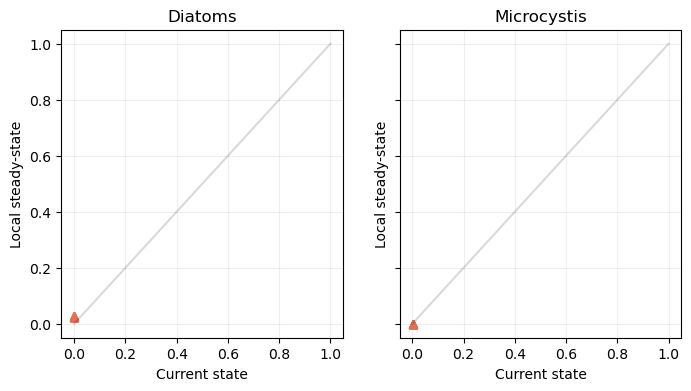

In [147]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=True, sharey=True)
axs = axs.flatten()

id = 1
ir = 1 
ik = 4
print("Depth = ", depth, " Ratio = ", ratio, " Kappa = ", kappa)

steadyD, steadyM = steady_state(depth, ratio, kappa, dst.d2.values[:, id ,ir,ik], dst.m2.values[:, id ,ir,ik], dst.n1.values[:, id ,ir,ik])


for it in range(1, 300, 20):
    n1 = dst.n1.values[it, id ,ir,ik]
    m1 = dst.m1.values[it, id ,ir,ik]
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]

    # local steady-state
    m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
    eig, j = jacobian(kappa, h1, h2, m1_eq, m2, d1_eq, d2, n1)
    
    # print(j)
    if j == 2:
        axs[0].plot(d1, d1_eq, '^', color="#56DBA6")
        axs[1].plot(m1, m1_eq, '^', color="#56DBA6")
    if j == -2:
        axs[0].plot(d1, d1_eq, 'o', color="#56DBA6")
        axs[1].plot(m1, m1_eq, 'o', color="#56DBA6")
    if j == -1:
        axs[0].plot(d1, d1_eq, 'o', color="#DB7256") #  
        axs[1].plot(m1, m1_eq, 'o', color="#DB7256") # stable 
    if j ==1:
        axs[0].plot(d1, d1_eq, '^', color="#DB7256")
        axs[1].plot(m1, m1_eq, '^', color="#DB7256") #  


for ax in axs:
    ax.set_xlabel("Current state")
    ax.set_ylabel("Local steady-state")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.grid(alpha=0.2, which='both')
    ax.plot([0, 1], [0, 1], color='black', alpha=0.15)
# axs[0].plot([], [], 'o', color="#56DBA6", label="Unstable (imag)")
# axs[0].plot([], [], '^', color="#56DBA6", label="Unstable (real)")
# axs[0].plot([], [], 'o', color="#DB7256", label="Stable (imag)")
# axs[0].plot([], [], '^', color="#DB7256", label="Stable (real)")

# axs[0].legend(fontsize=10, loc='upper right')
# axs[0].set_xlim(0, hours[-1])
axs[0].set_title("Diatoms")
axs[1].set_title("Microcystis")
# for ax in axs:
#     ax.set_yscale("log")
#     ax.grid(alpha=0.2, which='both'